**Praktikum 1**

OCR with Pytesseract and OpenCV

---

**Deskripsi**

Pada praktikum ini kita akan menerapkan teknik OCR dengan menggunakan tesseract dan openCV. Pytesseract or Python-tesseract merupakan alat OCR untuk Python yang juga berfungsi sebagai pembungkus untuk Mesin OCR Tesseract. Ia dapat membaca dan mengenali teks dalam gambar dan umumnya digunakan dalam kasus penggunaan ocr gambar ke teks menggunakan Python.

Selain itu juga berguna sebagai skrip panggilan mandiri untuk tesseract, karena dapat membaca semua jenis gambar yang didukung oleh perpustakaan gambar Pillow dan Leptonica, termasuk jpeg, png, gif, bmp, tiff, dan lainnya.

referensi lebih lengkap terkait pendekatan Python-tesseract dapat dibaca di [sini](https://github.com/madmaze/pytesseract).

**Dataset**

Dataset merupakan data citra yang digunakan dalam praktikum ini, pastikan koneksi Anda sebelum mengunduh dataset.

=> [DOWNLOAD](https://1drv.ms/u/s!Aibg5RCIk3G4jzvOODytEBZ6R7UP?e=UVw17t)

**Instalasi dan Import Library**

In [ ]:
from google.colab import drive # Digunakan untuk mengakses Google Drive dari Google Colab
drive.mount('/content/drive') # Menghubungkan Google Colab dengan Google Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!sudo apt install tesseract-ocr # Install paket tesseract-ocr
!pip install pytesseract # Install paket pytesseract
!pip install opencv-python # Intall paket opencv-python

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


In [ ]:
import re # Menyediakan fungsi-fungsi untuk melakukan manipulasi string menggunakan regular expression
import cv2 # Menyediakan fungsi-fungsi untuk pengolahan citra digital
import numpy as np # Menyediakan fungsi-fungsi untuk bekerja dengan array numerik
import pytesseract # Menyediakan fungsi-fungsi untuk pengolahan teks dalam citra (OCR - Optical Character Recognition)
from pytesseract import Output # Digunakan untuk menampung dan mengakses hasil OCR yang dilakukan oleh modul pytesseract
from matplotlib import pyplot as plt # menyediakan fungsi-fungsi untuk membuat grafik dan plot data

In [ ]:
IMG_DIR = '/content/drive/MyDrive/Machine Learning/Latihan/data/images-ocr/images/' # Jalur lokasi folder images

**Preprocessing images dengan OpenCV**

Pada tahap ini kita akan akan menulis fungsi dasar untuk metode prapemrosesan yang berbeda, meliputi:

- grayscaling
- thresholding
- dilating
- eroding
- opening
- canny edge detection
- noise removal
- deskwing
- template matching

Metode yang berbeda dapat berguna untuk jenis gambar yang berbeda

In [ ]:
# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # Mengembalikan hasil konversi citra dari BGR ke GRAY (Abu-abu)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image, 5) # Mengaplikasikan filter median blur pada gambar image dengan ukuran kernel 5x5

#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1] #  mengubah nilai piksel citra menjadi dua nilai, yaitu 0 (hitam) atau 255 (putih)

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8) # Membuat array numpy dengan ukuran 5x5 dengan 1 untuk setiap nilainya dengan tipe uint8
    return cv2.dilate(image, kernel, iterations = 1) # Memperbesar daerah piksel berdasarkan kernel dengan 1 kali iterasi (perulangan)

#erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8) # Membuat array numpy dengan ukuran 5x5 dengan 1 untuk setiap nilainya dengan tipe uint8
    return cv2.erode(image, kernel, iterations = 1) # Memperkecil daerah piksel berdasarkan kernel dengan 1 kali iterasi (perulangan)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8) # Membuat array numpy dengan ukuran 5x5 dengan 1 untuk setiap nilainya dengan tipe uint8
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel) # Melakukan proses opening (image dierosi kemudian didilasi) dengan memanfaatkan kernel

#opening - erosion followed by dilation
def closing(image):
    kernel = np.ones((5,5),np.uint8) # Membuat array numpy dengan ukuran 5x5 dengan 1 untuk setiap nilainya dengan tipe uint8
    return cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel) # Melakukan proses closing (image didilasi kemudian dierosi) dengan memanfaatkan kernel

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200) # Melakukan deteksi tepi dengan metode canny dengan batas minimum 100 dan maksimum 200

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0)) # Mendapatkan lokasi indeks setiap piksel yang memiliki nilai lebih dari 0 pada citra
    angle = cv2.minAreaRect(coords)[-1] # Mendapatkan sudut rotasi dari objek yang terdeteksi pada citra
    if angle < -45:
        angle = -(90 + angle) # Memperbaharui value angle dengan negasi 90 + value angle sebelumnya
    else:
        angle = -angle # Memperbaharui value angle negasi value angle sebelumnya
    (h, w) = image.shape[:2] # Memperoleh ukutan tinggi dan lebar citra
    center = (w // 2, h // 2) # Memperoleh pusat citra dengan pembulatan nilai w dan h yang dibagi 2
    M = cv2.getRotationMatrix2D(center, angle, 1.0) # Mendapatkan matriks rotasi 2D yang akan digunakan untuk memutar citra
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE) # Menerapkan transformasi affine (transformasi geometri yang dapat digunakan untuk memutar, menskalakan, dan menerjemahkan citra) pada gambar.
    return rotated # Mengembalikan value variabel rotated

#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED) # Melakukan Template Matching (mencari lokasi template pada image) dengan metode TM_CCOEFF_NORMED dari OpenCV

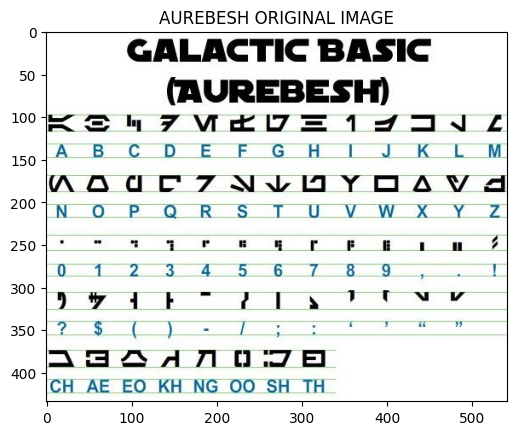

In [ ]:
# Plot original image

image = cv2.imread(IMG_DIR + 'aurebesh.jpg') # Memperoleh citra dengan detail file berdasarkan jalur dari IMG_DIR
b,g,r = cv2.split(image) # Mengambil value channel b, g dan r
rgb_img = cv2.merge([r,g,b]) # Menggabungkan value b, g, r dengan susunan baru menjadi r, g, dan b
plt.imshow(rgb_img) # Memilih citra yang akan ditampilkan dengan plt
plt.title('AUREBESH ORIGINAL IMAGE') # Menambahkan judul pada plt
plt.show() # Menampilkan plot

In [ ]:
# Preprocess image

gray = get_grayscale(image) # Memanggil function dengan argumen image untuk memperoleh citra Grayscale
thresh = thresholding(gray) # Melakukan thresholding dengan argumen variabel gray
dilated = dilate(gray) # Melakukan dilasi dengan argumen variabel gray
eroded = erode(gray) # Melakukan erosi dengan argumen variabel gray
opening = opening(gray) # Melakukan opening morphology pada citra gray
closing = closing(gray) # Melakukan closing morphology pada citra gray
skewed = deskew(gray) # Melakukan skew correction pada citra gray
noise_removed = remove_noise(gray) # Melakukan remove noise pada citra gray
canny = canny(gray) # Mendeteksi tepi citra dari gray
images = {'image': image,
          'gray': gray,
          'dilated': dilated,
          'eroded': eroded,
          'thresh': thresh,
          'opening': opening,
          'closing': closing,
          'skewed': skewed,
          'noise_removed': noise_removed,
          'canny': canny} # membuat dictionary dengan key dan value berikut

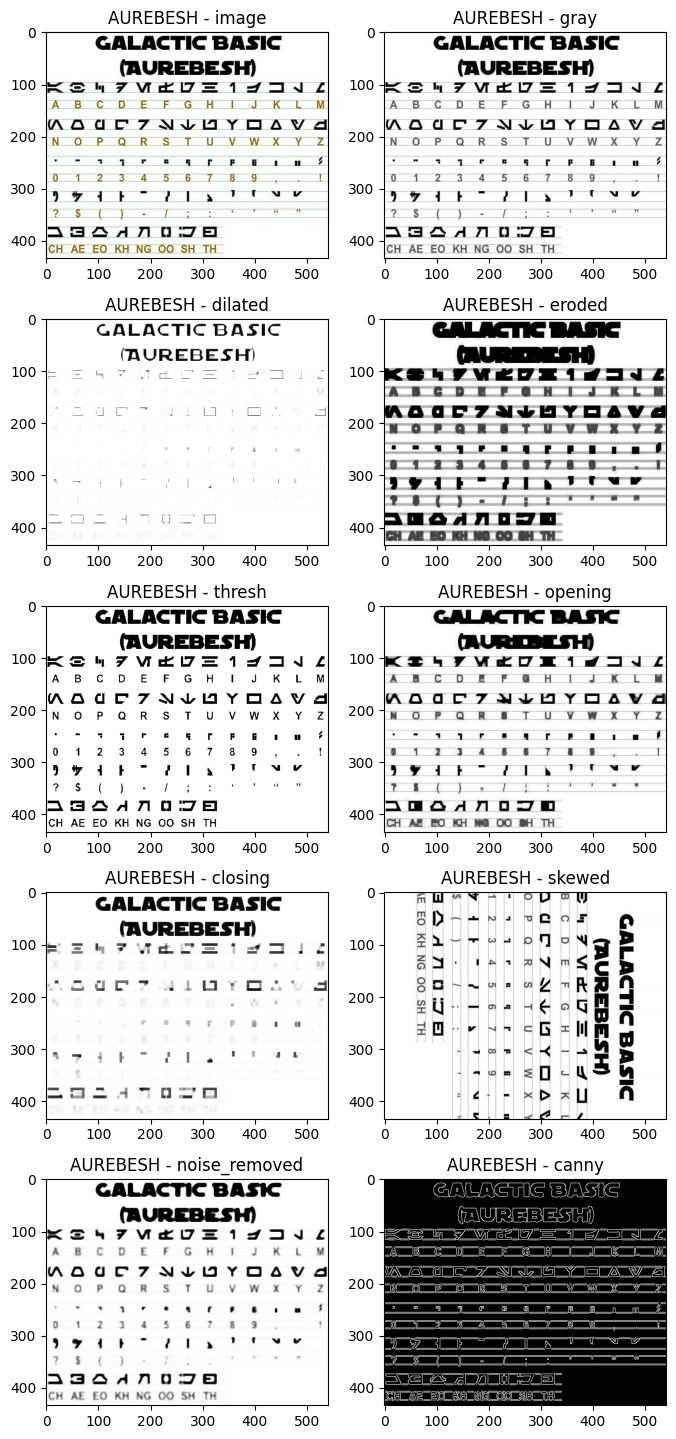

In [ ]:
# Plot images after preprocessing

fig = plt.figure(figsize=(8,18)) # Membuat plot dengan ukuran 8 inchi x 18 inchi
ax = [] # Membuat list awal untuk variabel ax

rows = 5 # Inisialisasi variabel rows dengan value 2
columns = 2 # Inisialisasi variabel column dengan value 2
keys = list(images.keys()) # Memperoleh list key dari dictionary image
for i in range(rows*columns): # Melakukan iterasi dari 0 sampai hasil rows dikali columns
    ax.append( fig.add_subplot(rows, columns, i+1) ) #  menambahkan subplot ke plot
    ax[-1].set_title('AUREBESH - ' + keys[i]) # Menambahkan judul untuk setiap subplot
    plt.imshow(images[keys[i]], cmap='gray') # Menampilkan citra indeks keys ke i dan cmap gray

In [ ]:
# Get OCR output using Pytesseract

custom_config = r'--oem 3 --psm 6' # menetapkan nilai konfigurasi kustom untuk Tesseract OCR
print('-----------------------------------------')
print('TESSERACT OUTPUT --> ORIGINAL IMAGE')
print('-----------------------------------------')
print(pytesseract.image_to_string(image, config=custom_config)) # Menampilkan teks hasil ekstraksi citra variabel image dari pytesseract
print('-----------------------------------------')
print('TESSERACT OUTPUT --> GRAY IMAGE')
print('-----------------------------------------')
print(pytesseract.image_to_string(gray, config=custom_config)) # Menampilkan teks hasil ekstraksi citra variabel gray dari pytesseract
print('-----------------------------------------')
print('TESSERACT OUTPUT --> DILATE IMAGE')
print('-----------------------------------------')
print(pytesseract.image_to_string(dilated, config=custom_config)) # Menampilkan teks hasil ekstraksi citra variabel dilated dari pytesseract
print('-----------------------------------------')
print('TESSERACT OUTPUT --> ERODE IMAGE')
print('-----------------------------------------')
print(pytesseract.image_to_string(eroded, config=custom_config)) # Menampilkan teks hasil ekstraksi citra variabel eroded dari pytesseract
print('\n-----------------------------------------')
print('TESSERACT OUTPUT --> THRESHOLDED IMAGE')
print('-----------------------------------------')
print(pytesseract.image_to_string(thresh, config=custom_config))  # Menampilkan teks hasil ekstraksi citra variabel thresh dari pytesseract
print('\n-----------------------------------------')
print('TESSERACT OUTPUT --> OPENED IMAGE')
print('-----------------------------------------')
print(pytesseract.image_to_string(opening, config=custom_config))  # Menampilkan teks hasil ekstraksi citra variabel opening dari pytesseract
print('\n-----------------------------------------')
print('TESSERACT OUTPUT --> CLOSED IMAGE')
print('-----------------------------------------')
print(pytesseract.image_to_string(closing, config=custom_config))  # Menampilkan teks hasil ekstraksi citra variabel closing dari pytesseract
print('\n-----------------------------------------')
print('TESSERACT OUTPUT --> NOISE REMOVED IMAGE')
print('-----------------------------------------')
print(pytesseract.image_to_string(noise_removed, config=custom_config))  # Menampilkan teks hasil ekstraksi citra variabel noise_removed dari pytesseract
print('\n-----------------------------------------')
print('TESSERACT OUTPUT --> SKEW IMAGE')
print('-----------------------------------------')
print(pytesseract.image_to_string(skewed, config=custom_config))  # Menampilkan teks hasil ekstraksi citra variabel skewed dari pytesseract
print('\n-----------------------------------------')
print('TESSERACT OUTPUT --> CANNY EDGE IMAGE')
print('-----------------------------------------')
print(pytesseract.image_to_string(image, config=custom_config))  # Menampilkan teks hasil ekstraksi citra variabel canny dari pytesseract

-----------------------------------------
TESSERACT OUTPUT --> ORIGINAL IMAGE
-----------------------------------------
GALACTIC BASIC
(AUREBESH)

RE TFVMVEVEStZIoNe
AB CD EF Ga KL
AOderT7NVYoYoOoOAVA
N_ Oo. 2 _ HG: Re SS Ty wee Ve
Ss eg ei
ed
i a a Sy ee ee ee
st
ASaSAnNADIE
CH AE EO KH NG OO SH TH

-----------------------------------------
TESSERACT OUTPUT --> GRAY IMAGE
-----------------------------------------
GALACTIC BASIC
(AUREBESH)
REehHTFVMVEVEITZIoIN EL
A 2S > EE eS A ek oe
AOder7NVYoYoAVaA
NOP RS Tn wee
‘ss 4 oe 8 g Pf fF f 4 mw 4
Sea
7 77 Ty
2S ys ee
ASaSAnNADI
CH AE EO KH NG OO SH TH

-----------------------------------------
TESSERACT OUTPUT --> DILATE IMAGE
-----------------------------------------
GALACTIC BASIC
(AUREBESH)
SBE yuMtPSiazro £
Te coy Nooo a
tz cri ee ee =

[ag lftadgnnvea

-----------------------------------------
TESSERACT OUTPUT --> ERODE IMAGE
-----------------------------------------
GALACTIC BASIC
(AUREBEESH)
KSEE TVEUVR iva Zz
A_5_C_D_E F 6 HTS KL